## References
https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning 

## Imports

In [1]:
import tensorflow as tf
import keras 
from keras import layers
from keras import optimizers
from keras import applications
from keras import losses
from keras import callbacks
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import csv
from sklearn.utils import shuffle

print("Modules imported")

Modules imported


## Colab

<a href="https://colab.research.google.com/github/SethCram/CS474-Deep-Learning/blob/main/HW4/HW4_CNN_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Google Colab Cell

#enable debugging
!pip install -Uqq ipdb
import ipdb
%pdb on

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/School/Senior Year/CS 474-01 (Deep Learning)/

#make sure GPU enabled
!nvidia-smi
#make sure TF can use GPU
if tf.test.gpu_device_name() == "":
    raise SystemError

# Data Import

      Unnamed: 0         img name  tumor types
0              0           000137            1
1              1         case0419            1
2              2         case0024            0
3              3     benign (397)            0
4              4         case0287            0
...          ...              ...          ...
2379        2379  malignant (143)            1
2380        2380         case0441            1
2381        2381     benign (162)            0
2382        2382           000064            0
2383        2383           000022            0

[2384 rows x 3 columns]


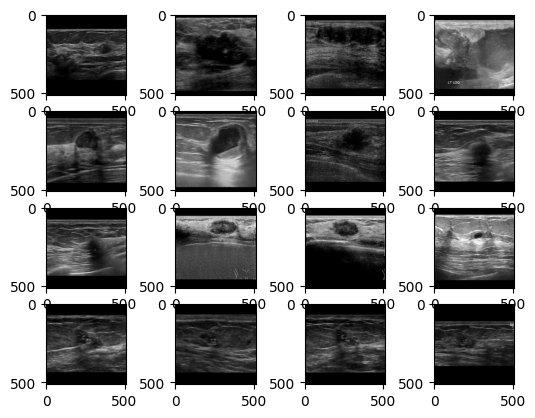

In [2]:
#LOAD CSV AND IMAGES (in proper resolution)

df=pd.read_csv('https://raw.githubusercontent.com/SethCram/CS474-Deep-Learning/main/HW4/train.csv', sep = ',')
print(df)

training_imgs_path = 'trainImgs/'
test_imgs_path = 'testImgs/'

targetWidth = 512 #500
targetHeight = 512 #500

# store training and test imgs greyscaled 
x_train = np.array([
            cv.resize( #resize to desired size
                cv.imread(training_imgs_path + row[1] + ".png"), 
                dsize=(targetWidth, targetHeight),
            ) 
            for row in df.values
    ])
x_test = np.array([
            cv.resize( #resize to desired size
                cv.imread(test_imgs_path + str(i) + ".png"),
                dsize=(targetWidth, targetHeight),
            )
            for i in range(1248)
    ])

#store whether benign (0?) or malignant (1?)
y_train = np.array([row[2] for row in df.values], dtype='float32')

nImg = 4  
for i in range(nImg*nImg):
    plt.subplot(nImg, nImg, i+1)
    plt.imshow(x_train[i])
plt.show()

# Transfer Learning
## Model Creation

### Comon Model Layers

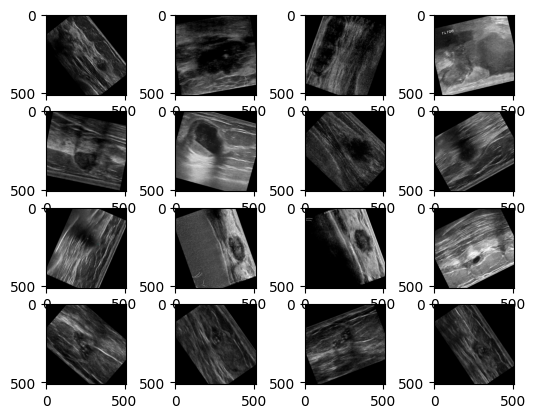

In [3]:
input_layer = layers.Input(shape=(targetWidth, targetHeight, 3))

#data augmentation
flip_layer = layers.RandomFlip()
rot_layer = layers.RandomRotation(
        0.2,
        fill_mode="constant",
        fill_value=0,
    )

output_layer = layers.Dense(
    units=1,
    activation=keras.activations.sigmoid 
)

nImg = 4  
for i in range(nImg*nImg):
    plt.subplot(nImg, nImg, i+1)
    
    aug_image = flip_layer(x_train[i])
    aug_image = rot_layer(aug_image)
    
    plt.imshow(aug_image.numpy().astype("uint8"))
plt.show()

### VGG Model

In [ ]:
## VGG

filename = "vgg16_firstpass_retry_model"

#avg = 530
#avg_training_width = sum( image.shape[0] for image in x_train ) / x_train.shape[0]
#avg_training_height = sum( image.shape[1] for image in x_train ) / x_train.shape[0]
#avg_test_width = sum( image.shape[0] for image in x_test ) / x_test.shape[0]
#avg_test_height = sum( image.shape[1] for image in x_train ) / x_train.shape[0]

# layer construction
preprocc_input = applications.vgg16.preprocess_input
base_model = applications.VGG16(
    input_shape=(targetWidth, targetHeight, 3),
    include_top=False,
)
flatten_layer = layers.Flatten()
fc_layer = layers.Dense(512, activation='relu')
# Add a dropout rate of 0.5
dropout_layer = layers.Dropout(0.5)

base_model.trainable = False

#layer connecting
x = flip_layer(input_layer)
#x = rot_layer(x)
x = preprocc_input(x) #training should be true here?
x = base_model(x, training=False)
x = flatten_layer(x)
x = fc_layer(x)
x = dropout_layer(x)
predictions = output_layer(x)
model = keras.Model(input_layer, predictions)

### InceptionV3 Model

In [59]:
filename = "inceptronv3_dropout3_finetuned2_model"

initial_epochs = 10

# layer construction
preprocc_input = applications.inception_v3.preprocess_input

base_model = applications.InceptionV3(
    input_shape=(targetWidth, targetHeight, 3),
    include_top=False,
)
base_model.trainable = False

global_avg_pool_layer = layers.GlobalAveragePooling2D()
fc_layer = layers.Dense(1024, activation='relu')
dropout_layer = layers.Dropout(0.2)

#layer connecting
x = flip_layer(input_layer)
#x = rot_layer(x)
x = preprocc_input(x) #training should be true here?
x = base_model(x, training=False)
x = global_avg_pool_layer(x)
x = fc_layer(x)
x = dropout_layer(x)
predictions = output_layer(x)
model = keras.Model(input_layer, predictions)

### Efficient Net Model

In [ ]:
filename = "EffNetV2S_firstpass_model"

# layer construction
preprocc_input = applications.efficientnet_v2.preprocess_input
base_model = applications.EfficientNetV2S(
    input_shape=(targetWidth, targetHeight, 3),
    include_top=False,
)
base_model.trainable = False

flatten_layer = layers.Flatten()
fc_layer = layers.Dense(1024, activation='relu')
dropout_layer = layers.Dropout(0.5) 

#layer connecting
x = flip_layer(input_layer)
#x = rot_layer(x)
x = preprocc_input(x) #training should be true here?
x = base_model(x, training=False)
x = flatten_layer(x)
x = fc_layer(x)
x = dropout_layer(x)
predictions = output_layer(x)
model = keras.Model(input_layer, predictions)

### ConvNext Model

In [ ]:
filename = "ConvNextTiny_firstpass_model"

# layer construction
base_model = applications.convnext.ConvNeXtTiny( #preproccing included
    input_shape=(targetWidth, targetHeight, 3),
    include_top=False,
)
base_model.trainable = False

flatten_layer = layers.Flatten()
fc_layer = layers.Dense(1024, activation='relu')
dropout_layer = layers.Dropout(0.3) 

#layer connecting
x = flip_layer(input_layer)
x = base_model(x, training=False)
x = flatten_layer(x)
x = fc_layer(x)
x = dropout_layer(x)
predictions = output_layer(x)
model = keras.Model(input_layer, predictions)

### MobileNet V2 Model

In [43]:
filename = "mobilenetv2_firstpass_finetuned3_model"

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(
        input_shape=(targetWidth, targetHeight, 3),
        include_top=False,
        weights='imagenet'
    )
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(targetWidth, targetHeight, 3))
x = rot_layer(inputs)
x = flip_layer(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Model Compilation

In [ ]:
base_learning_rate = 0.0001

model.compile(
    optimizer=optimizers.Adam(learning_rate=base_learning_rate), #optimizers.RMSprop(), #'adam', #optimizers.rmsprop(lr=0.0001, decay=1e-6) #sometimes decay not included?
    loss=losses.BinaryCrossentropy(), #or just categorical_crossentropy?
    metrics=['accuracy']
)

#model.summary(expand_nested=True, show_trainable=True)
model.summary()

In [60]:
base_learning_rate = 0.0001

model.compile(
    optimizer=optimizers.Adam(learning_rate=base_learning_rate/10), #optimizers.RMSprop(), #'adam', #optimizers.rmsprop(lr=0.0001, decay=1e-6) #sometimes decay not included?
    loss=losses.BinaryCrossentropy(), #or just categorical_crossentropy?
    metrics=['accuracy']
)

#model.summary(expand_nested=True, show_trainable=True)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 512, 512, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 512, 512, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

## Restore Model

In [61]:
## RESTORE THE MODEL

model = keras.models.load_model("saved_models/" + filename)

model.summary(expand_nested=True, show_trainable=True)

#filename = "inceptronv3_dropout3_finetuned3large_model"

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 512, 512, 3)]     0         Y          
                                                                            
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_1 (TFOpLam  (None, 512, 512, 3)      0         Y          
 bda)                                                                       
                                                                            
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_8 (InputLayer)      [(None, 512, 512, 3)]     0    

### Fine Tuning

shouldn't be finetuning if additional dense layer before output layer?

In [ ]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:

#base_model = model.layers[3]

#enable base model training
model.layers[4].trainable = True

# Fine-tune from this layer onwards
#fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
#for layer in model.layers[3].layers[:fine_tune_at]:
#  layer.trainable = False

#disable all base model layers
for base_model_layer in model.layers[3].layers:
    base_model_layer.trainable = False

#make some conv2D layers trainable
model.layers[4].layers[299].trainable = True

model.layers[4].layers[294].trainable = True

model.layers[4].layers[292].trainable = True
model.layers[4].layers[291].trainable = True
model.layers[4].layers[290].trainable = True
model.layers[4].layers[289].trainable = True

model.layers[4].layers[284].trainable = True
model.layers[4].layers[283].trainable = True


model.summary(expand_nested=True, show_trainable=True)

In [47]:
model.layers[5].trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[5].layers[:fine_tune_at]:
  layer.trainable = False
  
model.summary(expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         Y          
                                                                            
 random_rotation (RandomRota  (None, 512, 512, 3)      0         Y          
 tion)                                                                      
                                                                            
 random_flip (RandomFlip)    (None, 512, 512, 3)       0         Y          
                                                                            
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         Y          
 )                                                                          
                                                                            
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0     

### Recompiling

In [ ]:
#need to recompile model
model.compile(
    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9), #not sure why use SGD w/ mom
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [48]:
#need to recompile model
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=base_learning_rate/5), #optimizers.SGD(learning_rate=0.0001, momentum=0.9), #not sure why use SGD w/ mom
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Model Training

### Setup

In [62]:
#filename = "mobilenetv2_firstpass_finetuned3large2_model"

#shuffle data everytime train
x_train, y_train = shuffle(x_train, y_train)

batch_size = 32

early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=4,
    verbose=1,
    restore_best_weights=True
)

logger_callback = callbacks.CSVLogger(
    filename="model_logs/" + filename + '.csv',
    separator=',',
    append=True #don't overwrite if file exists already
)

### Fitting

In [63]:
#filename = "inceptronv3_dropout3_finetuned3large_model"

history = model.fit(
    x_train, #took first 500 for VGG
    y_train, #took first 500 for VGG
    epochs=initial_epochs, #5, 
    batch_size=batch_size,  #128, 64 crashed it; 40, 20 in both Epoch ETA is 10 mins didn't crash it (VGG)
    validation_split=0.2, 
    validation_batch_size=batch_size,
    shuffle=True, #shuffles data after every epoch to reduce overfitting
    callbacks=[early_stopping_callback, logger_callback],
    #should use mult proccing/threading?
    workers=4,
    use_multiprocessing = True,
)

Epoch 1/10
60/60 [==============================] - 236s 4s/step - loss: 0.3145 - accuracy: 0.8626 - val_loss: 0.2863 - val_accuracy: 0.8952
Epoch 2/10
60/60 [==============================] - 230s 4s/step - loss: 0.3061 - accuracy: 0.8658 - val_loss: 0.2744 - val_accuracy: 0.8889
Epoch 3/10
60/60 [==============================] - 226s 4s/step - loss: 0.3024 - accuracy: 0.8679 - val_loss: 0.2922 - val_accuracy: 0.8910
Epoch 4/10
60/60 [==============================] - 225s 4s/step - loss: 0.3023 - accuracy: 0.8778 - val_loss: 0.2885 - val_accuracy: 0.8889
Epoch 5/10
60/60 [==============================] - 224s 4s/step - loss: 0.2914 - accuracy: 0.8799 - val_loss: 0.2766 - val_accuracy: 0.8826
Epoch 5: early stopping


### Plotting

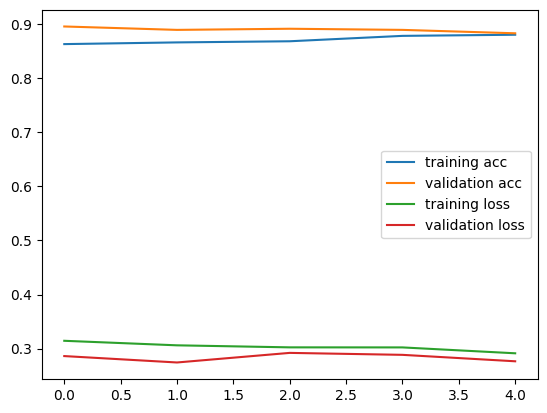

In [64]:
#history of training and validation accuracy (only works if model trained and not preloaded)
plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# Save Model

In [65]:
filename = "inceptronv3_dropout3_finetuned3.1_model"

## SAVE THE MODEL
model.save("saved_models/" + filename)

model.summary()

INFO:tensorflow:Assets written to: saved_models/inceptronv3_dropout3_finetuned3.1_model\assets


INFO:tensorflow:Assets written to: saved_models/inceptronv3_dropout3_finetuned3.1_model\assets


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 512, 512, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

# Model Evaluation
## Model Prediction

In [ ]:
## Model Prediction

batch_size = 32

#apply preprocessing to x_test too (results in skewed output all 1s)
#x_test = preprocc_input(x_test)

#test prediction storage
y_test_pred = model.predict(
        x_test, 
        batch_size=batch_size,
        workers=4,
        use_multiprocessing = True,
    ).flatten()

#round probabilities to 0 or 1
y_test_pred = np.round(y_test_pred)

with open('predictions/' + 'HW4_predictions_SethCram' + '_' + filename + '.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    
    for i in range(len(y_test_pred)):
        writer.writerow([str(i) + ".png", y_test_pred[i]])

## Train Accuracy

In [ ]:
#train accuracy
y_train_pred = model.predict(
        x_train, 
        batch_size=batch_size,
        #workers=4,
        #use_multiprocessing = True,
    ).flatten()

#round probabilities to 0 or 1
y_train_pred = np.round(y_train_pred)

train_acc = np.sum(y_train.flatten() == y_train_pred) / y_train.shape[0]

print(f'train accuracy: {train_acc * 100}%')

In [ ]:
loss0, accuracy0 = model.evaluate(x_train, batch_size=batch_size,)

In [58]:
weights = model.get_weights()

train_acc = np.sum(y_train.flatten() == y_train_pred) / y_train.shape[0]

pass

ImportError: cannot import name 'convnext' from 'tensorflow.keras' (c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\keras\api\_v2\keras\__init__.py)